In [1]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio.plot import show, show_hist
import rasterio
import rasterio.mask as Mask
import rasterio.features
import rasterio.warp
from rasterio.plot import show_hist
import fiona
import os
from PIL import Image
import glob
import shapely
from shapely.geometry import LineString, Polygon, Polygon, Point, MultiPoint, MultiPolygon
from functools import partial
import pyproj
import shapely
from shapely.ops import transform
from tqdm import tqdm_notebook, tqdm
import nibabel as nib ## help save 3D images
## help with figure rotation
from scipy import ndimage, misc
from shapely.geometry import Point
import geopandas as gpd
import cv2   # usse to resize images so that every image would have the same size!!!! 
## GDAL_DATA environment problem
os.environ['GDAL_DATA'] = '/opt/anaconda3/pkgs/libgdal-2.3.3-h0950a36_0/share/gdal'
#bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/landsat_path99_row85/bigquery_results.csv', index_col=0)
#len(bigquery_res)
import geopandas as gpd
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import fbeta_score


In [2]:
bigquery_res = pd.read_csv('/Volumes/My Passport for Mac/sentinel_2_53HPA/bigquery_results_s.csv', index_col=0)
bigquery_res['sensing_time'] = pd.to_datetime(bigquery_res['sensing_time'])
bigquery_res = bigquery_res.reset_index(drop=True)
subset_idx = np.array(bigquery_res[bigquery_res['cloud_cover']<75].index)
bigquery_res_s = bigquery_res.iloc[subset_idx,:]
bigquery_res_s = bigquery_res_s.reset_index(drop=True)


In [3]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def plot_rgb_from_tif(name='L1C_T53HPA_A004418_20180110T005319', 
                      BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/', 
                      figsize=(20,20),
                      plot=True,
                      crop=False,
                      crop_dict=None
                     ):
    
    if crop is False:    
        b2 = rasterio.open(BASE+name+'_b02.tif').read(1)
        b3 = rasterio.open(BASE+name+'_b03.tif').read(1)
        b4 = rasterio.open(BASE+name+'_b04.tif').read(1)
    else:
        '''to be continued'''
        with rasterio.open(BASE+name+'_b02.tif') as src:
            out_image, out_transform = Mask.mask(src, A, crop=True)
    
    
    b2 = np.expand_dims(b2, axis=2)
    b3 = np.expand_dims(b3, axis=2)
    b4 = np.expand_dims(b4, axis=2)
    b2 = normalize(b2)
    b3 = normalize(b3)
    b4 = normalize(b4)
    rgb = np.concatenate([b4,b3,b2], 2)
    if plot is True:
        plt.figure(figsize=figsize)
        plt.imshow(rgb)
    return rgb

In [4]:
bigquery_res_s[bigquery_res_s['granule_id']=='L1C_T53HPA_A009423_20181226T004702']

,granule_id,product_id,datatake_identifier,mgrs_tile,sensing_time,geometric_quality_flag,generation_time,north_lat,south_lat,west_lon,east_lon,base_url,total_size,cloud_cover
48,L1C_T53HPA_A009423_20181226T004702,S2B_MSIL1C_20181226T004659_N0207_R102_T53HPA_2...,GS2B_20181226T004659_009423_N02.07,53HPA,2018-12-26 00:57:01.700000+00:00,NaN,2018-12-26T02:03:54.000000Z,-35.221037,-36.227807,136.098931,137.33371,gs://gcp-public-data-sentinel-2/tiles/53/H/PA/...,743584777,0.0


In [5]:
rgb = plot_rgb_from_tif(name='L1C_T53HPA_A009423_20181226T004702', plot=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


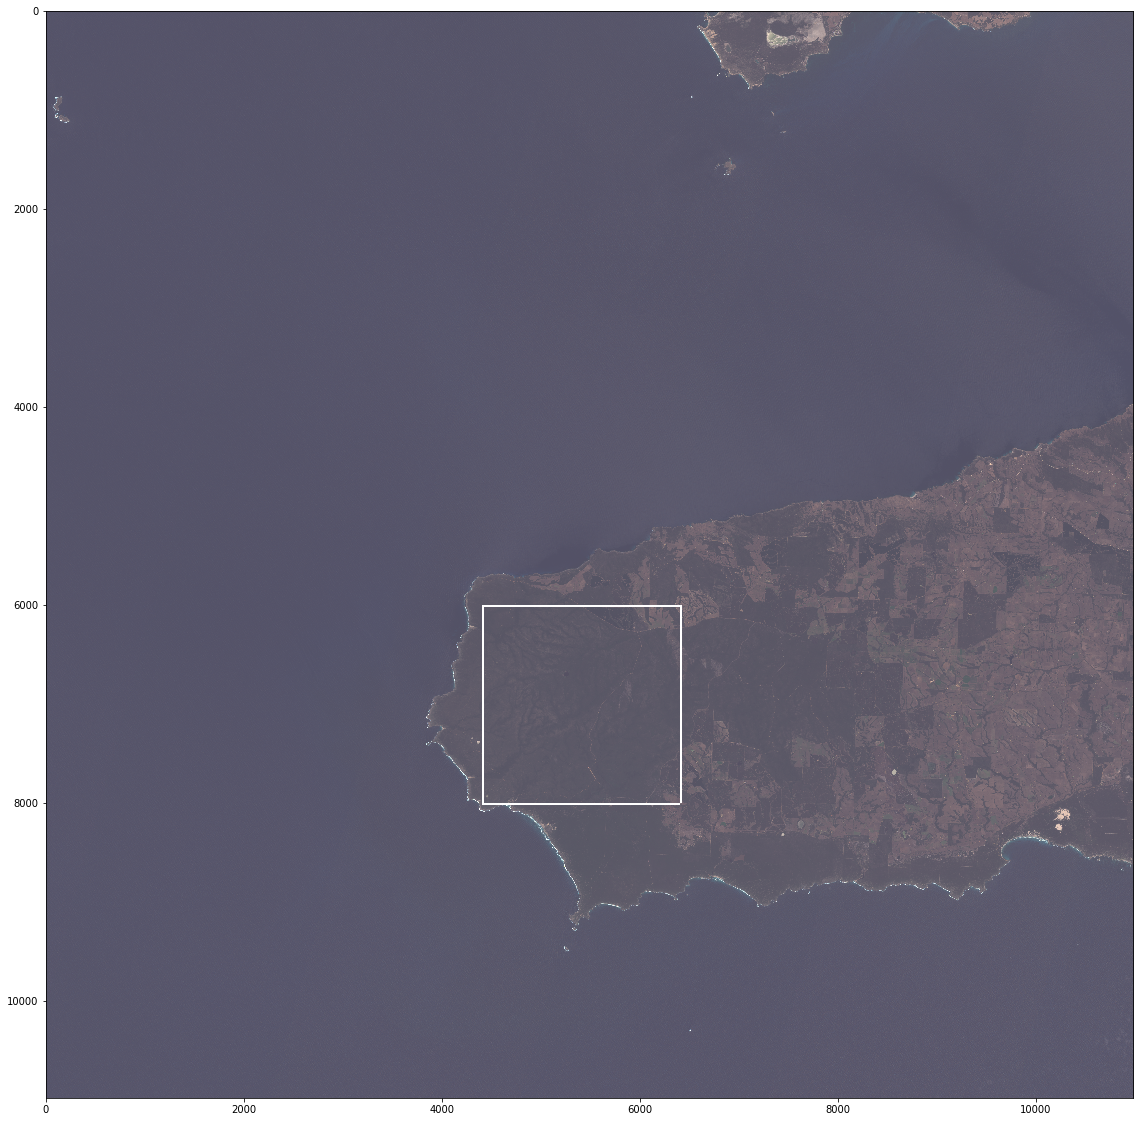

In [497]:
## Example RGB image
rgb[6000:8000,4400:4420,:] = 1
rgb[6000:8000,6400:6420,:] = 1
rgb[6000:6020,4400:6400,:] = 1
rgb[8000:8020,4400:6400,:] = 1

plt.figure(figsize=(20,20))
plt.imshow(rgb+0.3)

In [16]:
'''
rgb_list = []
for i in tqdm_notebook(range(len(bigquery_res_s))):
    rgb = plot_rgb_from_tif(name=bigquery_res_s['granule_id'][i], plot=False)
    rgb = np.expand_dims(rgb, 0)
    rgb_list.append(rgb)
rgb_array = np.array(rgb_list)
np.savez_compressed('rgb_array', rgb=rgb_array)
'''
rgb_array = np.load('/Users/jincui/Downloads/rgb_array.npz')['rgb']

In [21]:
imgs = np.load('/Users/jincui/Downloads/cloud_control_data.npz')['imgs']
smooth = 1e-5
b08 = imgs[:,:,:,7:8] 
b04 = imgs[:,:,:,3:4]
b12 = imgs[:,:,:,11:12]
ndvi= (b08-b04+smooth)/(b08+b04+smooth)
nbr = (b08-b12+smooth)/(b08+b12+smooth)

dndvi = []
for i in range(108):
    delta = ndvi[i,:] - ndvi[i+1,:]
    dndvi.append(delta)
dndvi = np.array(dndvi)

dnbr = np.load('/Users/jincui/Downloads/landsat_analysis/adjacency.npz')['dnbr']
dnbr = dnbr[:,200:1200,200:1200,:]


labs = (dnbr>0.66).astype(int)
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
for i in range(len(labs)):
    labs[i,:][water_mask==1] = 0
    
dnbr = dnbr.astype('float64')
dnbr_medians = np.zeros(len(dnbr))
for i in range(len(dnbr)):
    dnbr_medians[i] = np.median(dnbr[i,:,:,0]).round(2)
 

In [180]:
zones_labs = []
for i in range(25):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    zones_labs.append(labs[:,row_idx:row_idx+200,col_idx:col_idx+200,0])
zones_risk = np.array([*map(lambda t:(t.sum(axis=-1).sum(axis=-1) >= (0.05*200*200)).astype(int), zones_labs)])
zones_risk = np.swapaxes(zones_risk,0,1)

risks = np.zeros(labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(labs)):
        if labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1

In [195]:
folds_0 = np.load('/Users/jincui/Downloads/preds_0.npy').reshape((5,-1))
folds_1 = np.load('/Users/jincui/Downloads/preds_1.npy').reshape((5,-1))
folds_2 = np.load('/Users/jincui/Downloads/preds_2.npy').reshape((5,-1))
folds_3 = np.load('/Users/jincui/Downloads/preds_3.npy').reshape((5,-1))
folds_4 = np.load('/Users/jincui/Downloads/preds_4.npy').reshape((5,-1))

oof = np.concatenate([folds_0, folds_1, folds_2, folds_3, folds_4],0).transpose()
oof.shape

(106, 25)

In [193]:
y_true = zones_risk[2:,:].flatten()

In [196]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, cohen_kappa_score, confusion_matrix

print(accuracy_score(y_true, oof.round().flatten()))
print(f1_score(y_true, oof.round().flatten()))
print(fbeta_score(y_true, oof.round().flatten(),2))
print(fbeta_score(y_true, oof.round().flatten(),3))
print(fbeta_score(y_true, oof.round().flatten(),4))
print(cohen_kappa_score(y_true, oof.round().flatten()))
print(recall_score(y_true, oof.round().flatten()))
print(precision_score(y_true, oof.round().flatten()))


0.9479245283018868
0.6057142857142858
0.7593123209169054
0.8294209702660408
0.8622009569377991
0.5812013577458853
0.9137931034482759
0.452991452991453


In [197]:
test_preds_0 = np.load('/Users/jincui/Downloads/test_preds_0.npy')
test_preds_1 = np.load('/Users/jincui/Downloads/test_preds_1.npy')
test_preds_2 = np.load('/Users/jincui/Downloads/test_preds_2.npy')
test_preds_3 = np.load('/Users/jincui/Downloads/test_preds_3.npy')
test_preds_4 = np.load('/Users/jincui/Downloads/test_preds_4.npy')
test_preds_mean = 0.2*(test_preds_0+test_preds_1+test_preds_2+test_preds_3+test_preds_4)

test_labs = np.load('/Users/jincui/Downloads/test_data.npz')['test_lab']

In [198]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, cohen_kappa_score, confusion_matrix

print(accuracy_score(test_labs, test_preds_mean.round()))
print(f1_score(test_labs, test_preds_mean.round()))
print(fbeta_score(test_labs, test_preds_mean.round(),2))
print(fbeta_score(test_labs, test_preds_mean.round(),3))
print(fbeta_score(test_labs, test_preds_mean.round(),4))
print(cohen_kappa_score(test_labs, test_preds_mean.round()))
print(recall_score(test_labs, test_preds_mean.round()))
print(precision_score(test_labs, test_preds_mean.round()))


0.9333333333333333
0.9295774647887325
0.953757225433526
0.9620991253644315
0.9655765920826161
0.866500533997864
0.9705882352941176
0.8918918918918919


In [206]:
import seaborn as sns
sns.set(font_scale=2.2)

Text(0.5, 1.0, 'Test-set prediction\nTotal zones: 75\nNumber of time points: 3')

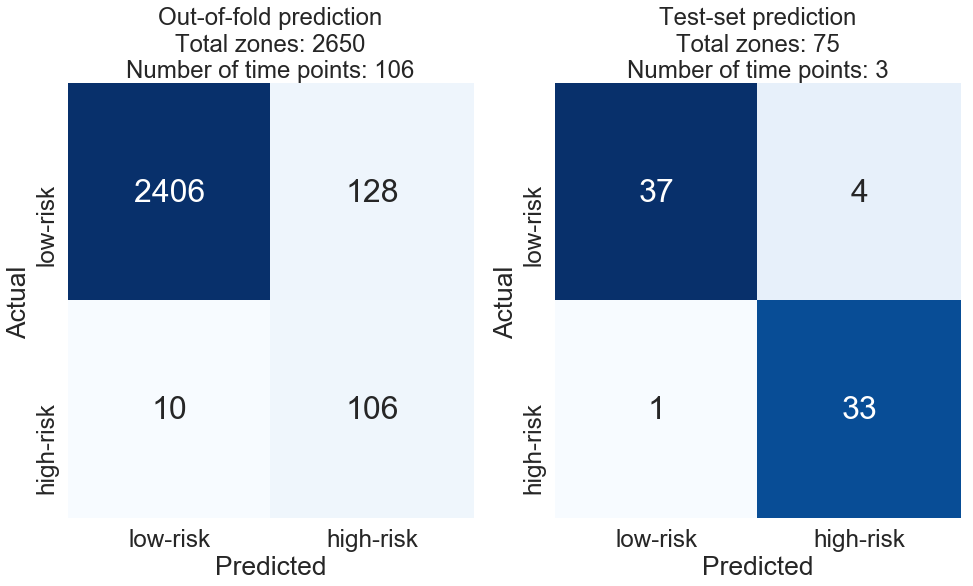

In [207]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)


cm = confusion_matrix(y_true, oof.round().flatten())
#cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
cm = pd.DataFrame(cm, index=['low-risk','high-risk'], columns=['low-risk','high-risk'])
annot = cm.values
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm, annot=annot, annot_kws={"size": 32}, cmap="Blues", fmt="d", cbar=False)
plt.title(f'Out-of-fold prediction\nTotal zones: {len(y_true)}\nNumber of time points: {len(y_true)//25}', fontdict={'size':24})

plt.subplot(1,2,2)
cm = confusion_matrix(test_labs, test_preds_mean.round())
#cm = pd.DataFrame(cm, index=np.unique(test_labs), columns=np.unique(test_labs))
cm = pd.DataFrame(cm, index=['low-risk','high-risk'], columns=['low-risk','high-risk'])
annot = cm.values
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
sns.heatmap(cm, annot=annot, annot_kws={"size": 32}, cmap="Blues", fmt="d", cbar=False)
plt.title(f'Test-set prediction\nTotal zones: {len(test_labs)}\nNumber of time points: {len(test_labs)//25}', fontdict={'size':24})
                                                                                                         

In [5]:
test_dates = ['2020-01-15','2020-01-20','2020-01-25','2020-01-30']

In [6]:
id_names = ['L1C_T53HPA_A023837_20200115T004700','L1C_T53HPA_A015000_20200120T005618','L1C_T53HPA_A023980_20200125T004659', 'L1C_T53HPA_A015143_20200130T005534']
def concat_bands(name='L1C_T53HPA_A004418_20180110T005319', 
                 BASE = '/Volumes/My Passport for Mac/sentinel_2_53HPA/'
                 ):
    '''Resize all bands to (5490, 5490), resolution at 20meter/pixel'''

    b01 = rasterio.open(BASE+name+'_b01.tif').read(1)
    b01 = np.expand_dims(cv2.resize(b01, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b09 = rasterio.open(BASE+name+'_b09.tif').read(1)
    b09 = np.expand_dims(cv2.resize(b09, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b10 = rasterio.open(BASE+name+'_b10.tif').read(1)
    b10 = np.expand_dims(cv2.resize(b10, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b02 = rasterio.open(BASE+name+'_b02.tif').read(1)
    b02 = np.expand_dims(cv2.resize(b02, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b03 = rasterio.open(BASE+name+'_b03.tif').read(1)
    b03 = np.expand_dims(cv2.resize(b03, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b04 = rasterio.open(BASE+name+'_b04.tif').read(1)
    b04 = np.expand_dims(cv2.resize(b04, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    b08 = rasterio.open(BASE+name+'_b08.tif').read(1)
    b08 = np.expand_dims(cv2.resize(b08, (5490,5490)), axis=2)[3000:4000,2200:3200,:]
    tci = rasterio.open(BASE+name+'_tci.tif').read(1)
    tci = np.expand_dims(cv2.resize(tci, (5490,5490)), axis=2)[3000:4000,2200:3200,:]

    b05 = np.expand_dims(rasterio.open(BASE+name+'_b05.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b06 = np.expand_dims(rasterio.open(BASE+name+'_b06.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b07 = np.expand_dims(rasterio.open(BASE+name+'_b07.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b8A = np.expand_dims(rasterio.open(BASE+name+'_b8A.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b11 = np.expand_dims(rasterio.open(BASE+name+'_b11.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    b12 = np.expand_dims(rasterio.open(BASE+name+'_b12.tif').read(1), axis=2)[3000:4000,2200:3200,:]
    
    concat = np.concatenate([b01,b02,b03,b04,b05,b06,b07,b08,b09,b10,b11,b12,b8A,tci],axis=-1)
    concat = np.expand_dims(concat, 0)
    return concat

for i in tqdm_notebook(range(len(id_names))):
    if i == 0:
        test_imgs = concat_bands(id_names[i])
    else:
        test_imgs = np.concatenate([test_imgs, concat_bands(id_names[i])])


In [7]:
smooth = 1e-5
test_nbr = (test_imgs[:,:,:,7:8]-test_imgs[:,:,:,11:12]+smooth) / (test_imgs[:,:,:,7:8]+test_imgs[:,:,:,11:12]+smooth)
test_nbr.shape

(4, 1000, 1000, 1)

In [8]:
test_dnbr = np.zeros((3,1000,1000,1))
for i in range(len(test_dnbr)):
    test_dnbr[i,:] = test_nbr[i,:] - test_nbr[i+1,:]

In [13]:
water_mask = np.load('../../water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)
test_binarized_labs = (test_dnbr > 0.66).astype(int)
for i in range(len(test_binarized_labs)):
    test_binarized_labs[i,:][water_mask==1] = 0
test_binarized_labs.shape

(3, 1000, 1000, 1)

In [14]:
test_zones_labs = []
for i in range(25):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    test_zones_labs.append(test_binarized_labs[:,row_idx:row_idx+200,col_idx:col_idx+200,0])
    
test_zones_risk = np.array([*map(lambda t:(t.sum(axis=-1).sum(axis=-1) >= (0.05*200*200)).astype(int), test_zones_labs)])
test_zones_risk = np.swapaxes(test_zones_risk,0,1)

test_risks = np.zeros(test_binarized_labs.shape)
from tqdm import tqdm_notebook
for i in tqdm_notebook(range(25)):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    for j in range(len(test_binarized_labs)):
        if test_binarized_labs[j,row_idx:row_idx+200,col_idx:col_idx+200,0].sum() >= 0.05*200*200:
            test_risks[j,row_idx:row_idx+200,col_idx:col_idx+200,0] = 1
            

In [18]:

test_preds = test_preds_mean.reshape((-1,3)).transpose()

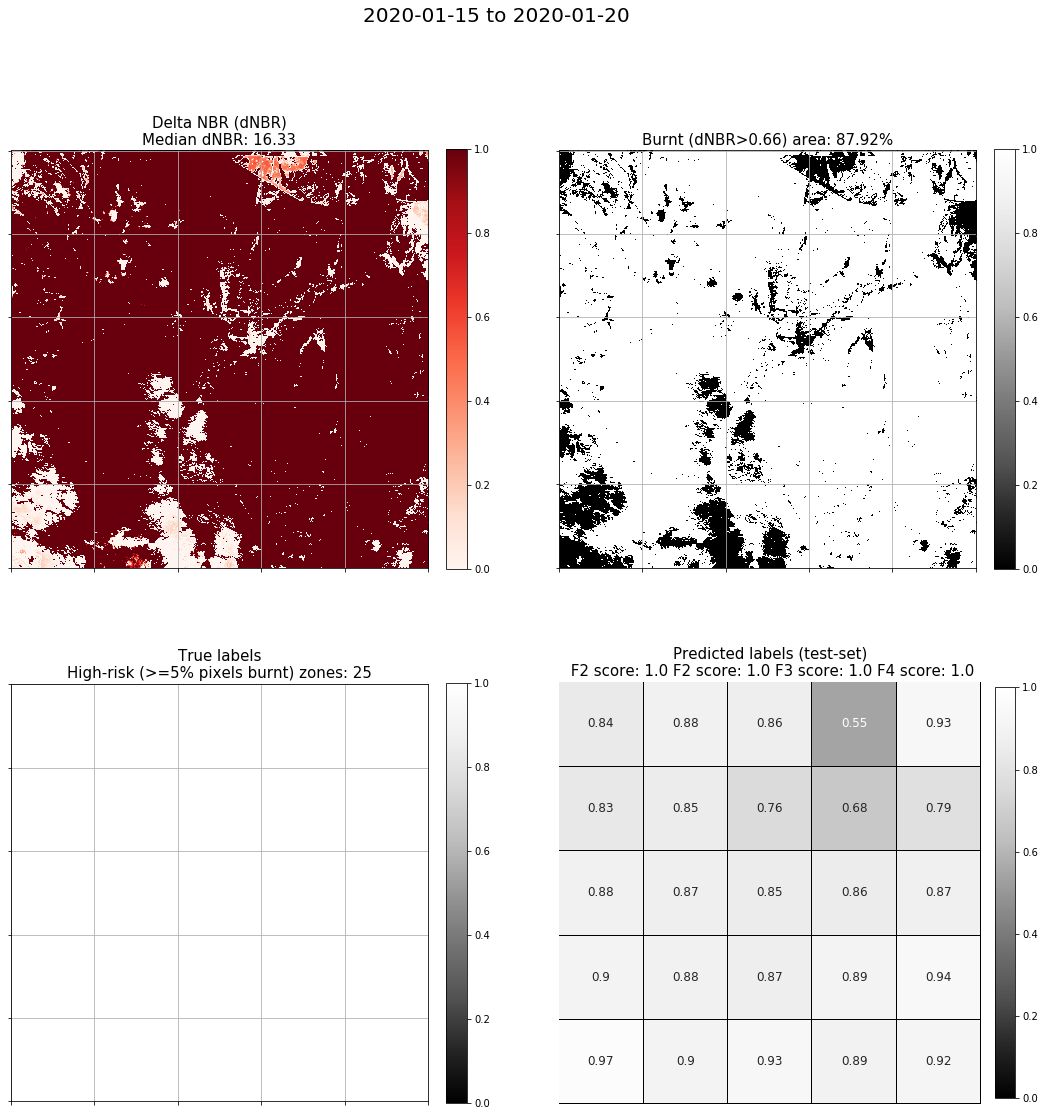

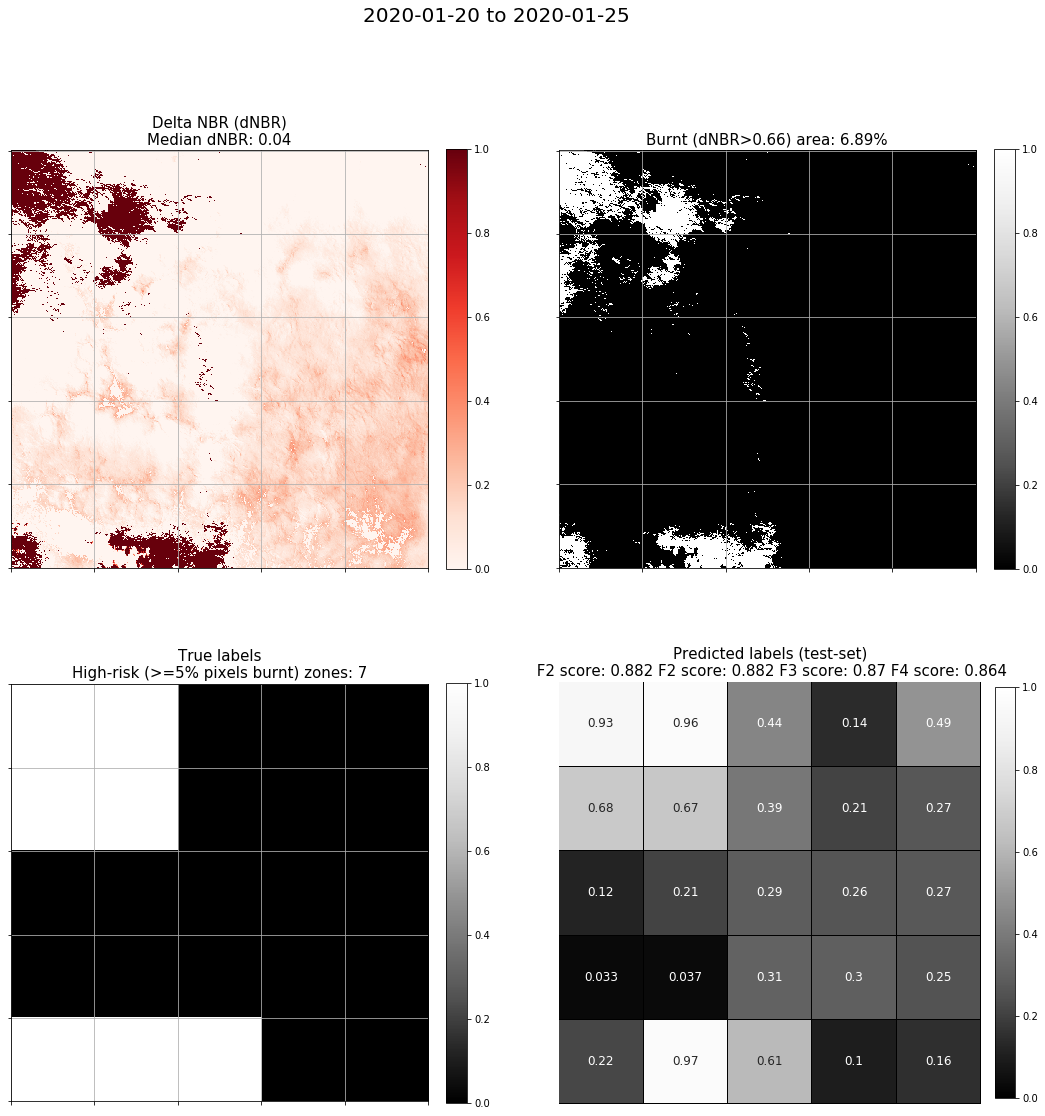

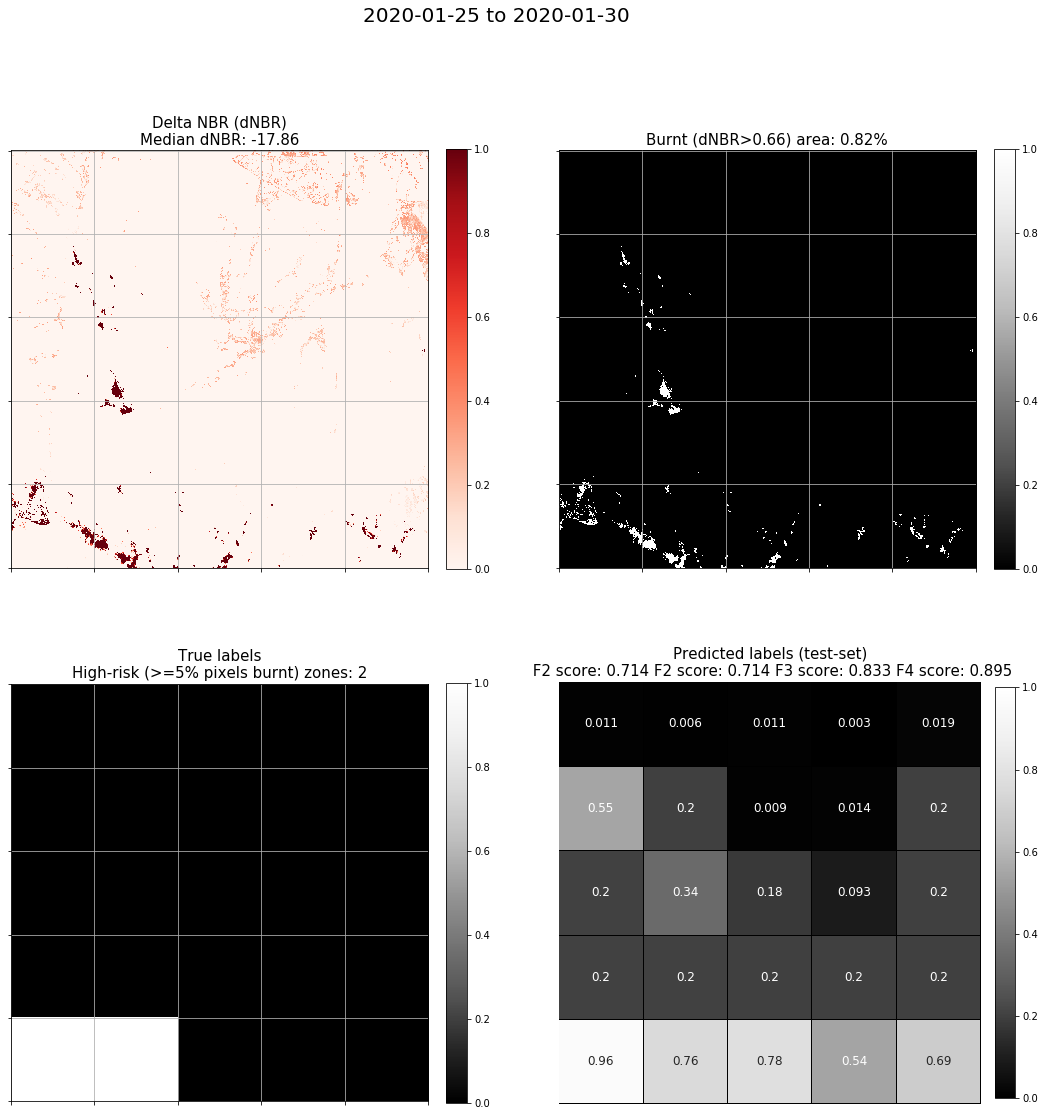

In [19]:
for i in tqdm_notebook(range(108, 111)):
    '''Recursively generate figures for my Dash app'''
    thres = 0.66
    subtitle_fontsize=20
    title_fontsize=15
    if i < 108:
        pass

    else:
        plt.figure(figsize=(18,18))
        plt.suptitle(f"{test_dates[i-108]} to {test_dates[i-107]}", fontsize=subtitle_fontsize)
        plt.subplot(2,2,1)
        plt.grid()
        plt.imshow(test_dnbr[i-108,:,:,0], 
                   #cmap='RdYlGn_r', vmin=-1, vmax=1
                   cmap='Reds', vmin=0, vmax=1
                  )
                    
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {np.median(test_dnbr[i-108,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(2,2,2)
        plt.grid()
        plt.imshow(test_binarized_labs[i-108,:,:,0].astype(int), cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)        
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Burnt (dNBR>0.66) area: {(100*(test_binarized_labs[i-108,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)

        plt.subplot(2,2,3)
        plt.grid()
        plt.imshow(test_risks[i-108,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"True labels\nHigh-risk (>=5% pixels burnt) zones: {test_zones_risk[i-108].sum()}", fontsize=title_fontsize)

        plt.subplot(2,2,4)
        plt.grid()
        cm = test_preds[i-108,:]
        annot = test_preds[i-108,:].round(3)
        sns.heatmap(cm.reshape((5,5)), annot=annot.reshape((5,5)), cmap="Greys_r", cbar=False, vmin=0, vmax=1,
                    annot_kws={"size": 12}, 
                    #cbar_kws={"shrink": .7, "location":"right", "use_gridspec":False},
                    yticklabels=False, xticklabels=False,
                    square=True, linecolor='black', linewidths=0.005
        )
        plt.colorbar(fraction=0.045, pad=0.03)
        plt.title(f"Predicted labels (test-set)\n F2 score: {fbeta_score(test_zones_risk[i-108,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 2).round(3)} F2 score: {fbeta_score(test_zones_risk[i-108,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 2).round(3)} F3 score: {fbeta_score(test_zones_risk[i-108,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 3).round(3)} F4 score: {fbeta_score(test_zones_risk[i-108,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 4).round(3)}", fontsize=title_fontsize)
        plt.savefig(f"../Dash_app/data/plot_folder/plot_{test_dates[i-108+1]}.png")

        #print(test_dates[i-108+1])

In [26]:
all_labs = np.concatenate([labs, test_binarized_labs],0)
all_labs.shape

(111, 1000, 1000, 1)

In [67]:
SUM = all_labs.sum(axis=-1).sum(axis=-1).sum(axis=-1)
BURN_RATIO = (100*SUM/(1000**2))
dates = bigquery_res_s['sensing_time'][1:].dt.date.map(str).values.tolist()
dates.extend(['2020-01-20', '2020-01-25', '2020-01-30'])
dates = np.array(dates)
xticks = np.array([*map(lambda t:"" if t not in ['2018-08-18', '2020-01-20'] else t, dates)])


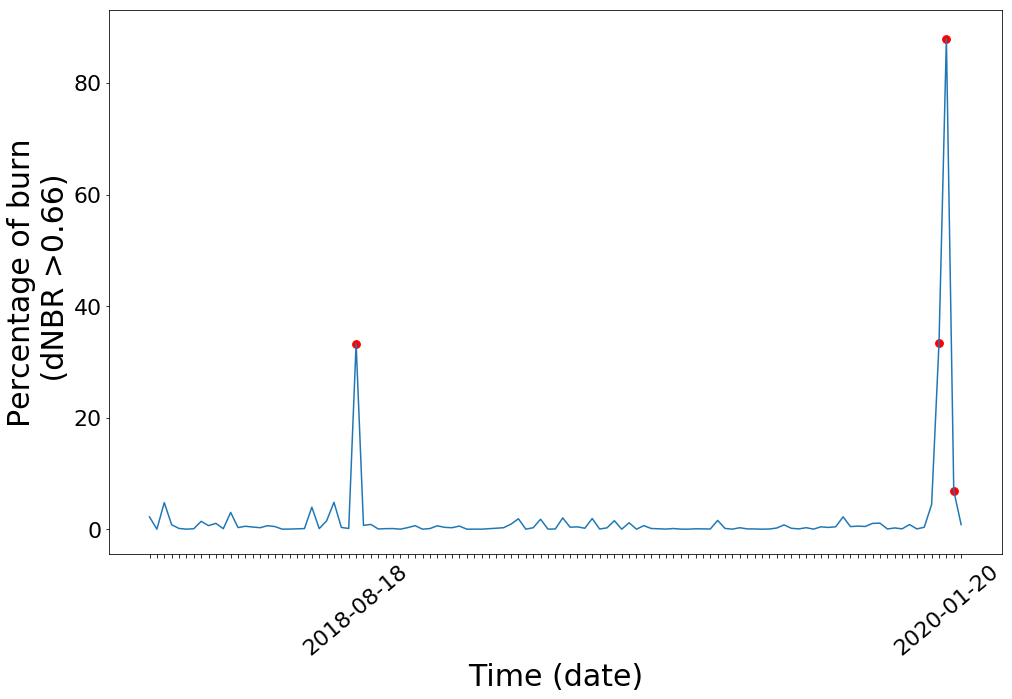

In [175]:
##### Custom xticks achieved with seaborn

plt.figure(figsize=(16,10))
plot = sns.lineplot(dates, BURN_RATIO)
plot.set_xticklabels(xticks, rotation=40, horizontalalignment='center',
    #fontweight='light',
    fontsize=22)
plt.xlabel('Time (date)', fontdict={'size':30})
plt.ylabel('Percentage of burn\n (dNBR >0.66)', fontdict={'size':30})
plt.yticks(fontsize=22)
plt.scatter(dates[np.where(BURN_RATIO > 5)[0]], BURN_RATIO[np.where(BURN_RATIO > 5)[0]], s=60, c='r')


In [184]:
all_zones_labs = []
for i in range(25):
    row_idx = (i//5)*200
    col_idx = (i%5)*200
    all_zones_labs.append(all_labs[:,row_idx:row_idx+200,col_idx:col_idx+200,0])
all_zones_risk = np.array([*map(lambda t:(t.sum(axis=-1).sum(axis=-1) >= (0.05*200*200)).astype(int), all_zones_labs)])
all_zones_risk = np.swapaxes(all_zones_risk,0,1)


In [189]:
1-all_zones_risk.mean()

0.9452252252252252

In [60]:
BURN_RATIO.shape

(111,)

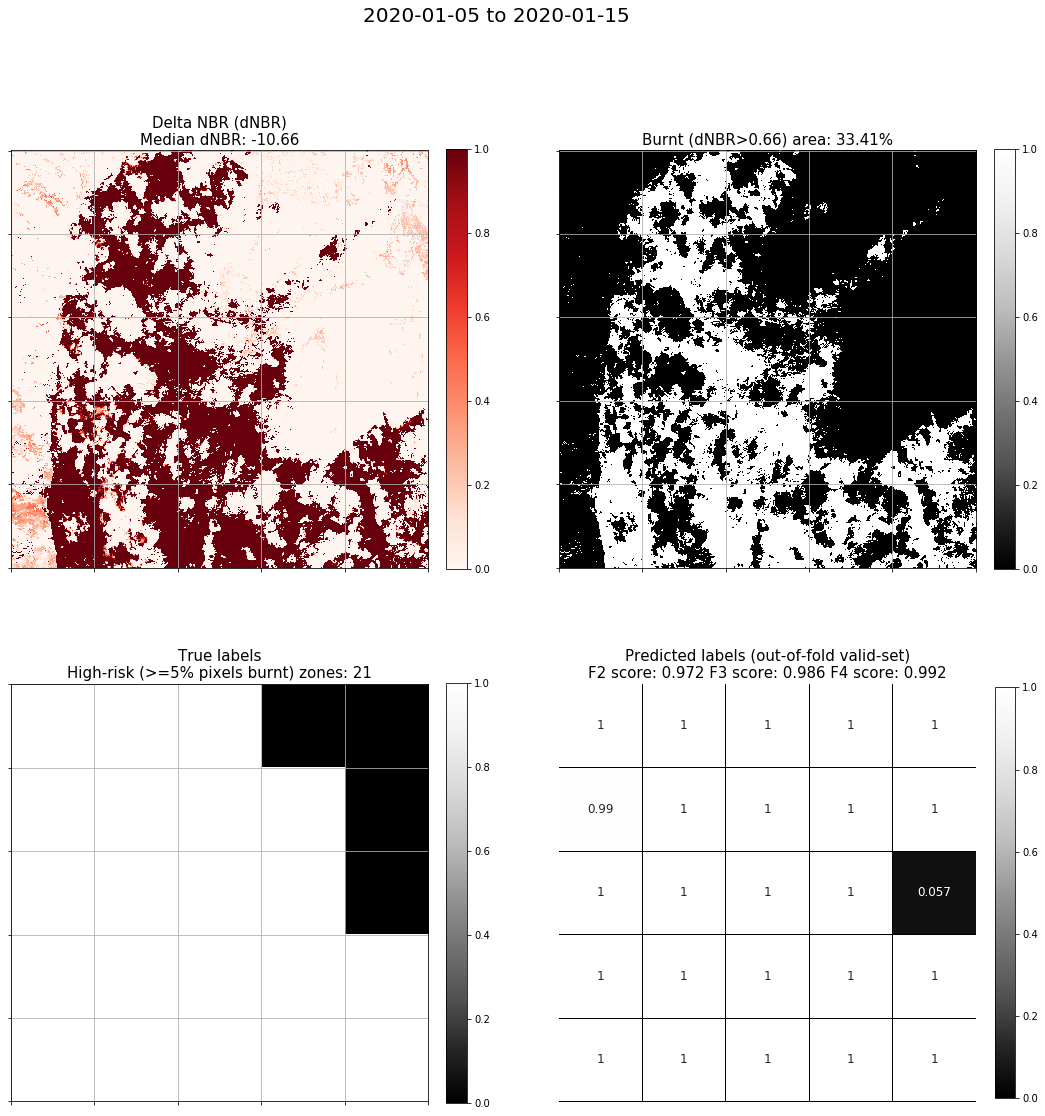

In [21]:
########## FINAL VERSION ##########
def cross_entropy(targets, predictions, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions))/N
    return ce

def weighted_crossentropy(targets, predictions, weight=10):
    
    return (cross_entropy(targets, predictions) + weight*cross_entropy(1-targets, 1-predictions))/(1+weight)

#for i in tqdm_notebook(range(1, 108+2)):

for i in tqdm_notebook(range(107, 108)):
    '''Recursively generate figures for my Dash app'''
    thres = 0.66
    subtitle_fontsize=20
    title_fontsize=15
    if i < 108:
        plt.figure(figsize=(18,18))
        plt.suptitle(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i]} to {bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}", fontsize=subtitle_fontsize)

        plt.subplot(2,2,1)
        plt.grid()
        plt.imshow(dnbr[i,:,:,0], 
                   #cmap='RdYlGn_r', vmin=-1, vmax=1
                   cmap='Reds', vmin=0, vmax=1
                  )
                     
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {np.median(dnbr[i,:,:,0]).round(2)}", fontsize=title_fontsize)
                     
        plt.subplot(2,2,2)
        plt.grid()
        plt.imshow(labs[i,:,:,0].astype(int), cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Burnt (dNBR>0.66) area: {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)


        plt.subplot(2,2,3)
        plt.grid()
        plt.imshow(risks[i,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"True labels\nHigh-risk (>=5% pixels burnt) zones: {zones_risk[i].sum()}", fontsize=title_fontsize)

        if i >=2 :
            plt.subplot(2,2,4)
            plt.grid()
            cm = pd.DataFrame(oof[i-2,:].reshape((5,5)))
            annot = cm.apply(lambda t:t.round(3)).values
            sns.heatmap(cm, annot=annot, annot_kws={"size": 12}, cmap="Greys_r", vmin=0, vmax=1,
                        yticklabels=False, xticklabels=False, cbar=False, #cbar_kws={"shrink": .8},
                        square=True, linecolor='black', linewidths=0.005
            )
            plt.colorbar(fraction=0.045, pad=0.04)
            #plt.title(f"Predicted labels (out-of-fold valid-set)\n F2 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 2).round(3)}\n Weighted cross-entropy: {combined_crossentropy(zones_risk[i,:], oof[i-2,:]).round(3)}", fontsize=title_fontsize)
            plt.title(f"Predicted labels (out-of-fold valid-set)\nF2 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 2).round(3)} F3 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 3).round(3)} F4 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 4).round(3)}", fontsize=title_fontsize)
        
        plt.savefig(f"../Dash_app/data/plot_folder/plot_{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}.png")


    else:
        plt.figure(figsize=(18,18))
        plt.suptitle(f"{test_dates[i-108]} to {test_dates[i-107]}", fontsize=subtitle_fontsize)
        
        plt.subplot(2,2,1)
        plt.grid()
        plt.imshow(test_dnbr[i-105,:,:,0], 
                   #cmap='RdYlGn_r', vmin=-1, vmax=1
                  cmap='Reds', vmin=0, vmax=1
                  )
                    
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {(-1)*np.median(test_dnbr[i-105,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(2,2,2)
        plt.grid()
        plt.imshow(test_labs[i-105,:,:,0].astype(int), cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)        
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Burnt (dNBR>0.66) area: {(100*(test_labs[i-105,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)

        plt.subplot(2,2,3)
        plt.grid()
        plt.imshow(test_risks[i-105,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"True labels\nHigh-risk (>=5% pixels burnt) zones: {test_zones_risk[i-105].sum()}", fontsize=title_fontsize)

        plt.subplot(2,2,4)
        plt.grid()
        cm = test_preds[i-108,:]
        annot = test_preds[i-108,:].round(3)
        sns.heatmap(cm, annot=annot, cmap="Greys_r", cbar=False, vmin=0, vmax=1,
                    annot_kws={"size": 12}, 
                    #cbar_kws={"shrink": .7, "location":"right", "use_gridspec":False},
                    yticklabels=False, xticklabels=False,
                    square=True, linecolor='black', linewidths=0.005
        )
        plt.colorbar(fraction=0.045, pad=0.03)
        plt.title(f"Predicted labels (test-set)\n F2 score: {fbeta_score(test_zones_risk[i-105,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 2).round(3)}\n Weighted cross-entropy: {combined_crossentropy(test_zones_risk[i-105,:], test_preds[i-108,:].flatten()).round(3)}", fontsize=title_fontsize)
        plt.savefig(f"../Dash_app/data/plot_folder/plot_{test_dates[i-108+1]}.png")



In [ ]:
for i in tqdm_notebook(range(106,108+2)):
    '''Recursively generate figures for my Dash app'''
    thres = 0.66
    subtitle_fontsize=20
    title_fontsize=15

    
    if i < 108:
        plt.figure(figsize=(18,18))
        plt.suptitle(f"{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i]} to {bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}", fontsize=subtitle_fontsize)

        plt.subplot(3,3,1)
        plt.grid()
        plt.imshow(rgb_array[i+1,0,:,:,:])
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title("True color (RGB)", fontsize=title_fontsize)

        plt.subplot(3,3,2)
        plt.grid()
        plt.imshow(ndvi[i+1,:,:,0], cmap='Greens', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Normalized vegetation index (NDVI)\nMedian NDVI: {np.median(ndvi[i+1,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,3)
        plt.grid()
        plt.imshow(dndvi[i,:,:,0], cmap='Greens', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NDVI (dNDVI)\nMedian dNDVI: {np.median(dndvi[i,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,4)
        plt.grid()
        """!"""
        plt.imshow(nbr[i+1,:,:,0], cmap='RdYlGn', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Normalized burn ratio (NBR)\nMedian NBR: {np.median(nbr[i+1,:,:,0]).round(2)}", fontsize=title_fontsize)
        plt.subplot(3,3,5)
        plt.grid()
        plt.imshow(dnbr[i,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {np.median(dnbr[i,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,6)
        plt.grid()
        plt.imshow(labs[i,:,:,0].astype(int), cmap='Greys_r')
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Burnt (dNBR>0.66) area: {(100*(labs[i,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)

        plt.subplot(3,3,7)
        plt.grid()
        plt.imshow(risks[i,:,:,0], cmap='Greys_r', vmin=0, vmax=1)

        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"True labels\nHigh-risk (>=5% pixels burnt) zones: {zones_risk[i].sum()}", fontsize=title_fontsize)

        if i >=2 :
            plt.subplot(3,3,8)
            #cm = pd.DataFrame(preds_risks[i-1,:])
            cm = pd.DataFrame(oof[i-2,:].reshape((5,5)))
            annot = cm.apply(lambda t:t.round(3)).values
            sns.heatmap(cm, annot=annot, annot_kws={"size": 12}, cmap="Greys_r", cbar=False, vmin=0, vmax=1,
                        yticklabels=False, xticklabels=False
            )

            #plt.title(f"Predicted labels\n F2 score: {fbeta_score(zones_risk[i+1,:], (preds_risks[i-1,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)
            plt.title(f"Predicted labels (out-of-fold prediction)\n F2 score: {fbeta_score(zones_risk[i,:], (oof[i-2,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)
        plt.savefig(f"../Dash_app/data/plot_folder/plot_{bigquery_res_s['sensing_time'].dt.date.map(lambda t:str(t))[i+1]}.png")

    
    elif i>= 108:
        plt.figure(figsize=(18,18))
        plt.suptitle(f"{test_dates[i-108]} to {test_dates[i-107]}", fontsize=subtitle_fontsize)
        
        plt.subplot(3,3,1)
        plt.grid()
        plt.imshow(test_rgb[i-104,:])
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title("True color (RGB)", fontsize=title_fontsize)

        plt.subplot(3,3,2)
        plt.grid()
        plt.imshow(test_ndvi[i-104,:,:,0], cmap='Greens', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Normalized vegetation index (NDVI)\nMedian NDVI: {np.median(test_ndvi[i-104,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,3)
        plt.grid()
        plt.imshow(test_dndvi[i-105,:,:,0], cmap='Greens', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NDVI (dNDVI)\nMedian dNDVI: {np.median(test_dndvi[i-105,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,4)
        plt.grid()
        plt.imshow(test_nbr[i-104,:,:,0], cmap='RdYlGn', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Normalized burn ratio (NBR)\nMedian NBR: {np.median(test_nbr[i-104,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,5)
        plt.grid()
        plt.imshow(test_dnbr[i-105,:,:,0], cmap='RdYlGn_r', vmin=-1, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Delta NBR (dNBR)\nMedian dNBR: {(-1)*np.median(test_dnbr[i-105,:,:,0]).round(2)}", fontsize=title_fontsize)

        plt.subplot(3,3,6)
        plt.grid()
        plt.imshow(test_labs[i-105,:,:,0].astype(int), cmap='Greys_r')
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"Burnt (dNBR>0.66) area: {(100*(test_labs[i-105,:,:,0].sum())/(1000*1000)).round(2)}%", fontsize=title_fontsize)

        plt.subplot(3,3,7)
        plt.grid()
        plt.imshow(test_risks[i-105,:,:,0], cmap='Greys_r', vmin=0, vmax=1)
        plt.xticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.yticks([0,200,400,600,800,1000], labels=['','','','',''])
        plt.title(f"True labels\nHigh-risk (>=5% pixels burnt) zones: {test_zones_risk[i-105].sum()}", fontsize=title_fontsize)

        plt.subplot(3,3,8)
        plt.grid()
        cm = test_preds[i-108,:]
        annot = test_preds[i-108,:].round(3)
        sns.heatmap(cm, annot=annot, cmap="Greys_r", cbar=False, vmin=0, vmax=1,
                    annot_kws={"size": 12}, 
                    #cbar_kws={"shrink": .7, "location":"right", "use_gridspec":False},
                    yticklabels=False, xticklabels=False)
        plt.title(f"Predicted labels (test-set prediction)\n F2 score: {fbeta_score(test_zones_risk[i-105,:], (test_preds[i-108,:]>0.5).flatten().astype(int), 2).round(3)}", fontsize=title_fontsize)
        plt.savefig(f"../Dash_app/data/plot_folder/plot_{test_dates[i-108]}.png")
                 
    

                

['2020-01-20', '2020-01-25']

In [215]:
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score, roc_auc_score, accuracy_score
y_true = zones_risk[2:].flatten()
y_pred = oof.round().flatten()
print(f"{recall_score(y_true, y_pred).round(3)}\t{fbeta_score(y_true, y_pred, 2).round(3)} \t {f1_score(y_true, y_pred).round(3)}\t{cohen_kappa_score(y_true, y_pred).round(3)}\t{roc_auc_score(y_true, y_pred).round(3)}\t{accuracy_score(y_true, y_pred).round(3)}\t{precision_score(y_true, y_pred).round(3)}")


0.902	0.711 	 0.54	0.502	0.91	0.917	0.385


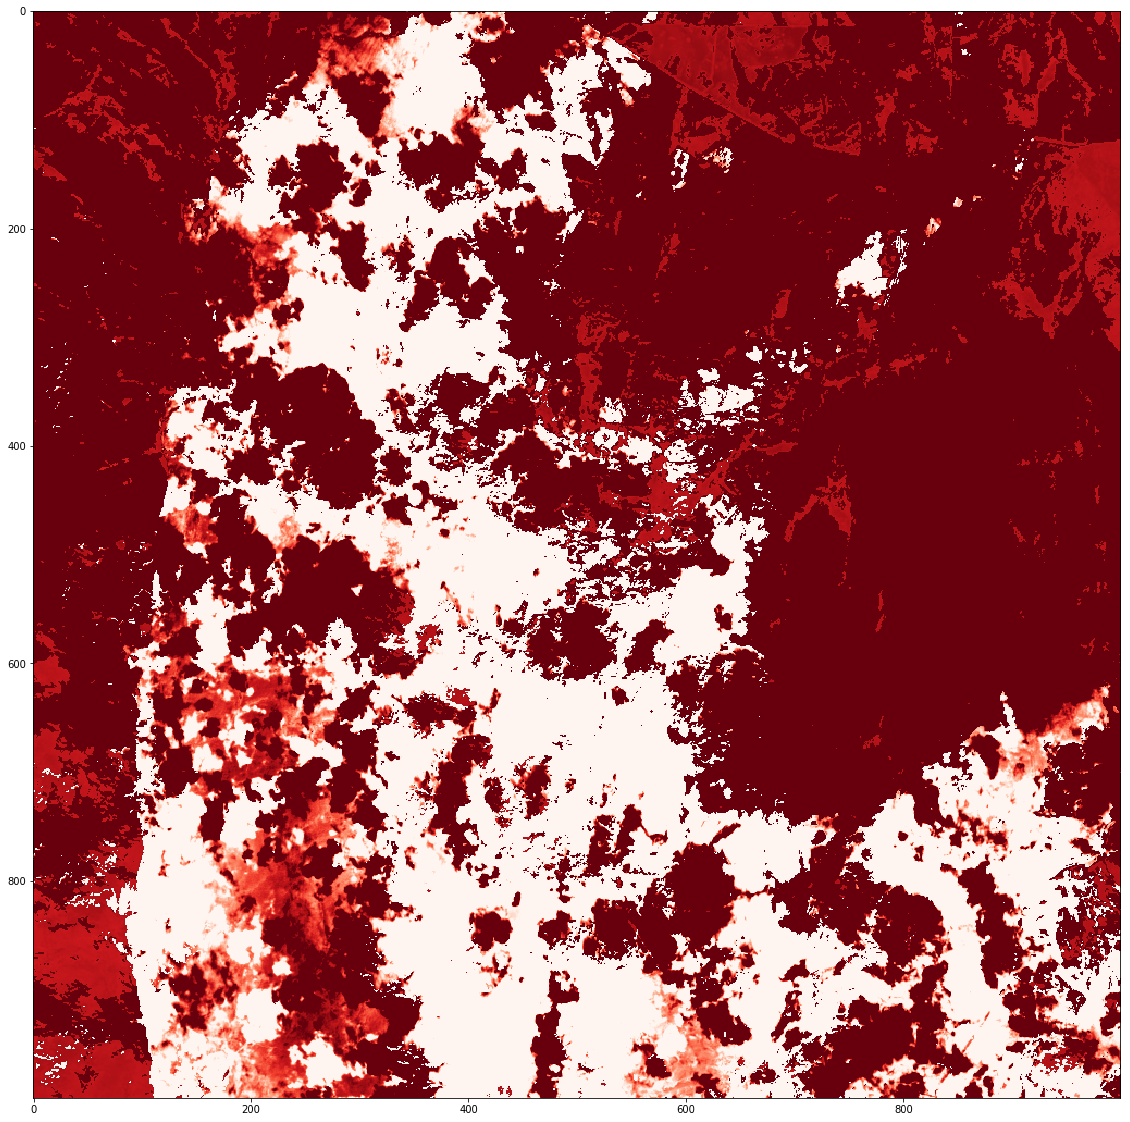

In [228]:
plt.figure(figsize=(20,20))
plt.imshow(dnbr[-1,:,:,0], cmap='Reds', vmin=-5, vmax=1)